## SQL Project Planning

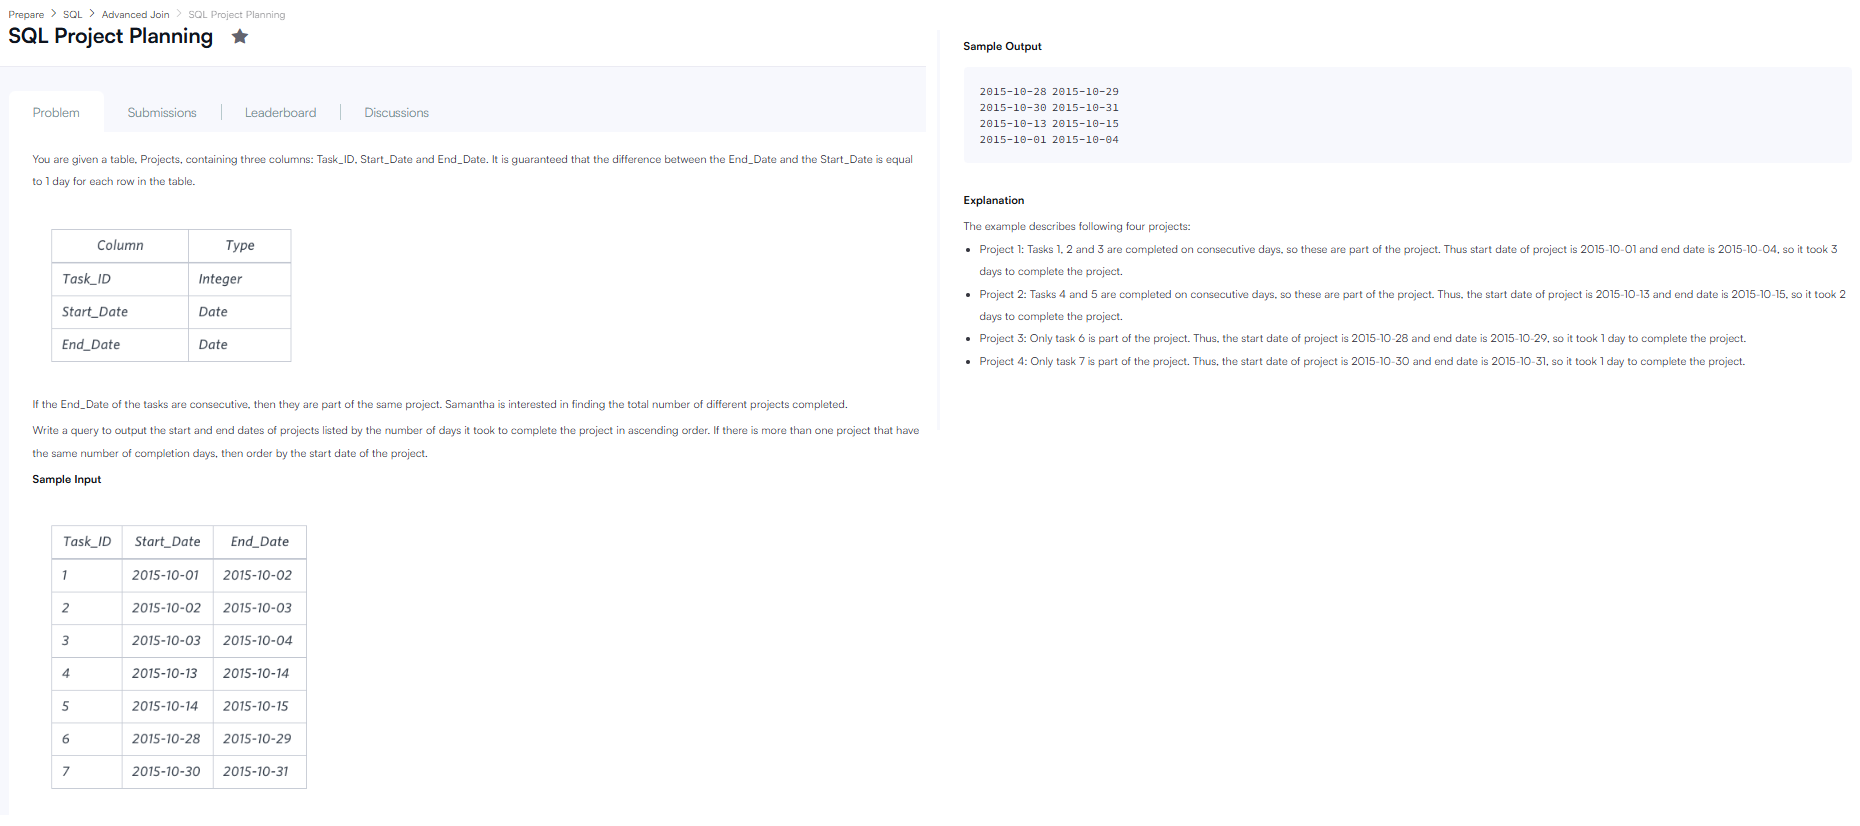

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DateType, IntegerType
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [0]:
spark = SparkSession.builder.appName("SQL Project Planning").getOrCreate()

In [0]:
# dbutils.fs.ls('/FileStore/HackerRank')
# dbutils.fs.rm('/FileStore/HackerRank/Project.csv')

In [0]:
## Define schema
projects_schema = StructType(
    [StructField('task_id', IntegerType(), False)
     ,StructField('start_date', DateType(), False)
     , StructField('end_date', DateType(), False)])

In [0]:
## Import data from CSV
projects_df = spark.read.csv('dbfs:/FileStore/HackerRank/Projects.csv', schema=projects_schema, header=True)
display(projects_df.orderBy(F.col('start_date')))

task_id,start_date,end_date
1,2015-10-01,2015-10-02
24,2015-10-02,2015-10-03
2,2015-10-03,2015-10-04
23,2015-10-04,2015-10-05
3,2015-10-11,2015-10-12
22,2015-10-12,2015-10-13
4,2015-10-15,2015-10-16
21,2015-10-17,2015-10-18
5,2015-10-19,2015-10-20
20,2015-10-21,2015-10-22


In [0]:
## Create spark SQL view
projects_df.createOrReplaceTempView('projects')

##Expected Output
2015-10-15 2015-10-16 \
2015-10-17 2015-10-18 \
2015-10-19 2015-10-20 \
2015-10-21 2015-10-22 \
2015-11-01 2015-11-02 \
2015-11-17 2015-11-18 \
2015-10-11 2015-10-13 \
2015-11-11 2015-11-13 \
2015-10-01 2015-10-05 \
2015-11-04 2015-11-08 \
2015-10-25 2015-10-31 
 

### SQL Solution

In [0]:
%sql
with sd as ( 
  select start_date from projects where start_date not in (select end_date from projects) --Get non consecutive start dates
), 
ed as (
select end_date from projects where end_date not in (select start_date from projects) --Get non consecutive end dates
) 
select start_date, end_date 
from (
select ed.end_date, sd.start_date, rank() over (partition by sd.start_date order by ed.end_date) rnk 
  from sd join ed 
on sd.start_date < ed.end_date -- Compare dates
) where rnk =1 --Get the first row for each start date
order by (end_date - start_date) -- list rows by number of days it took to complete the project in ascending order. 

start_date,end_date
2015-10-15,2015-10-16
2015-10-17,2015-10-18
2015-10-19,2015-10-20
2015-10-21,2015-10-22
2015-11-01,2015-11-02
2015-11-17,2015-11-18
2015-10-11,2015-10-13
2015-11-11,2015-11-13
2015-10-01,2015-10-05
2015-11-04,2015-11-08


In [0]:
%sql
select start_date from projects where start_date not in (select end_date from projects)

start_date
2015-10-01
2015-10-11
2015-10-15
2015-10-17
2015-10-19
2015-10-21
2015-10-25
2015-11-01
2015-11-04
2015-11-11


## Pyspark Solution

In [0]:
%sql
--Get non consecutive start dates
-- select start_date from projects where start_date not in (select end_date from projects) -- This query can be written as below
select a.start_date, b.end_date from projects a 
left outer join projects b 
on a.start_date = b.end_date 
where b.end_date is null 

start_date,end_date
2015-10-01,null
2015-10-11,null
2015-10-15,null
2015-10-17,null
2015-10-19,null
2015-10-21,null
2015-10-25,null
2015-11-01,null
2015-11-04,null
2015-11-11,null


In [0]:
# Step 1
# --Get non consecutive start dates. Convert the above to pyspark
start_date_df = projects_df.alias('a')\
    .join(projects_df.alias('b'), F.col('a.start_date') == F.col('b.end_date'), how='left')\
        .where(F.col('b.end_date').isNull())\
            .select(F.col('a.start_date'))
display(start_date_df)

start_date
2015-10-01
2015-10-11
2015-10-15
2015-10-17
2015-10-19
2015-10-21
2015-10-25
2015-11-01
2015-11-04
2015-11-11


In [0]:
## Step 2
## --Get non consecutive end dates. Similar as above
## select end_date from projects where end_date not in (select start_date from projects)
end_date_df = projects_df.alias('a')\
    .join(projects_df.alias('b'), F.col('a.end_date') == F.col('b.start_date'), how='left')\
        .where(F.col('b.start_date').isNull())\
            .select(F.col('a.end_date'))
display(end_date_df)

end_date
2015-10-05
2015-10-13
2015-10-16
2015-10-18
2015-10-20
2015-10-22
2015-10-31
2015-11-02
2015-11-08
2015-11-13


In [0]:
# Step 3 - Join above two dataframes
# select ed.end_date, sd.start_date, rank() over (partition by sd.start_date order by ed.end_date) rnk 
#   from sd join ed 
# on sd.start_date < ed.end_date -- Compare dates
window_spec = Window.partitionBy('start_date').orderBy('end_date')
main_df = start_date_df.join(end_date_df, F.col('start_date') < F.col('end_date'), how='inner').withColumn('rnk', F.rank().over(window_spec))
display(main_df)

start_date,end_date,rnk
2015-10-01,2015-10-05,1
2015-10-01,2015-10-13,2
2015-10-01,2015-10-16,3
2015-10-01,2015-10-18,4
2015-10-01,2015-10-20,5
2015-10-01,2015-10-22,6
2015-10-01,2015-10-31,7
2015-10-01,2015-11-02,8
2015-10-01,2015-11-08,9
2015-10-01,2015-11-13,10


In [0]:
# Step 4 - Filter and order final result set
# where rnk =1 --Get the first row for each start date
# order by (end_date - start_date) -- list rows by number of days it took to complete the project in ascending order. 
result_df = main_df.where(F.col('rnk') == 1).orderBy(F.col('end_date') - F.col('start_date')).select(F.col('start_date'), F.col('end_date'))
display(result_df)

start_date,end_date
2015-10-15,2015-10-16
2015-10-17,2015-10-18
2015-10-19,2015-10-20
2015-10-21,2015-10-22
2015-11-01,2015-11-02
2015-11-17,2015-11-18
2015-10-11,2015-10-13
2015-11-11,2015-11-13
2015-10-01,2015-10-05
2015-11-04,2015-11-08


## Pyspark Alternative
### SQL 'not in (select ...)' subquery can be done with pyspark apis using '~' and 'isin' and passing a list. This requires the dataframe to be converted to a list.
select start_date from projects where start_date not in (select end_date from projects)

Note: The flatMap(lambda x: x).collect() part is used to convert the DataFrame column to a list. However, be cautious with collect() for large datasets as it brings all data to the driver node. For very large datasets, you might want to consider using a join operation instead.

See code below

In [0]:
# Step 1: Get all end_dates
end_dates = projects.select("end_date").distinct()

# Step 2: Select start_dates that are not in end_dates
result = projects.select("start_date").where(~F.col("start_date").isin(end_dates.rdd.flatMap(lambda x: x).collect()))